## **Object Detection**

#### **(1) KITTI 데이터 셋**
#### **(2) RetinaNet**  
#### **(3) 자율주행 보조 시스템 만들기**

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2

import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw

print(tf.__version__)
print(cv2.__version__)
print(np.__version__)
print(PIL.__version__)

2.9.0
4.6.0
1.22.3
9.5.0


---

### **(1) KITTI 데이터 셋**  
  
자율주행을 위한 2D, 3D 데이터 셋

https://www.cvlibs.net/datasets/kitti/

|Values|    Name |     Description|  
|:---:|:---:|:---|  
|   1  | type     |    Describes the type of object: 'Car', 'Van', 'Truck',<br/>'Pedestrian', 'Person_sitting', <br/>'Cyclist', 'Tram', 'Misc' or 'DontCare'|  
|   1  |  truncated|    Float from 0 (non-truncated) to 1 (truncated), <br/>where truncated refers to the object leaving image boundaries|  
|   1  |  occluded  |   Integer (0,1,2,3) indicating occlusion state: <br/>0 = fully visible, <br/>1 = partly occluded,<br/>2 = largely occluded, <br/>3 = unknown|  
|   1   | alpha      |  Observation angle of object, ranging [-pi..pi]|  
|   4    |bbox        | 2D bounding box of object in the image (0-based index):<br/>contains left, top, right, bottom pixel coordinates|  
|   3    |dimensions   |3D object dimensions: height, width, length (in meters)|  
|   3    |location     |3D object location x,y,z in camera coordinates (in meters)|  
|   1    |rotation_y   |Rotation ry around Y-axis in camera coordinates [-pi..pi]|  
|   1    |score        |Only for results: Float, indicating confidence in <br/>detection, needed for p/r curves, higher is better.|  

In [2]:
DATA_PATH = '/Users/yena/tensorflow_datasets'

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-07-04 11:57:02.701237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-04 11:57:02.701393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-07-04 11:57:02.778575: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


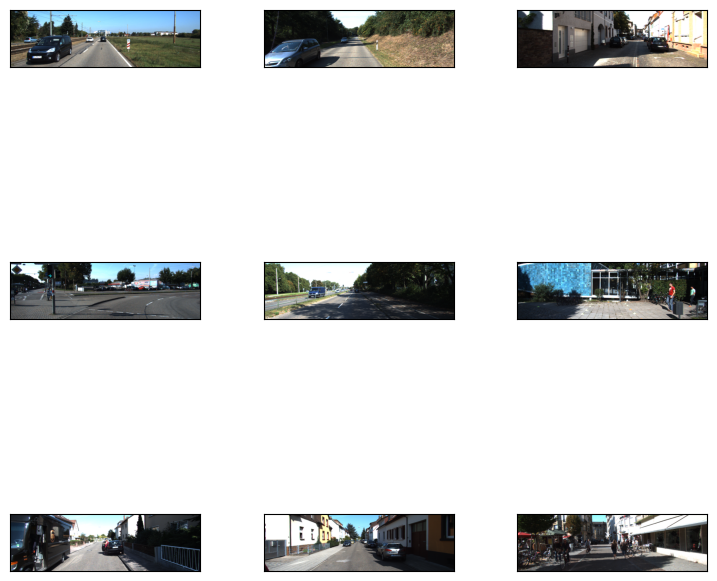

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.3.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/Users/yena/tensorflow_datasets/kitti/3.3.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'objects': Sequence({
            'alpha': fl

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 2.77,  0.  , -0.16, -0.31, -0.52, -2.03, -2.87,  0.91,  1.51],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.36748663, 0.39933765, 0.5365775 , 0.42894992],
       [0.40791443, 0.22223748, 0.6523262 , 0.29494345],
       [0.4229679 , 0.29382068, 0.6717112 , 0.4298223 ],
       [0.45320857, 0.41815025, 0.67983955, 0.48717287],
       [0.47005346, 0.4707189 , 0.69029415, 0.6754927 ],
       [0.0026738 , 0.7401454 , 0.4050802 , 0.8661147 ],
       [0.0026738 , 0.80447495, 0.42671123, 0.91597736],
       [0.0026738 , 0.6823506 , 0.40631017, 0.78273827],
       [0.01564171, 0.7530937 , 0.44866312, 0.82940227]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[ 1.61,  0.87,  1.03],
       [ 3.48,  2.75,  3.22],
       [ 3.68,  2.81,  6.69],
       [ 3.65,  2.8 ,  3.14],
 

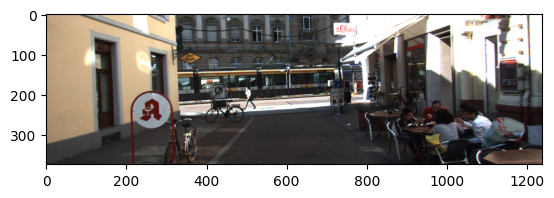

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

[494.38 275.13 363.75 517.67 582.75 916.3  995.94 844.75 932.33] [ 531.04     365.13998  532.12     603.12     836.25995 1072.25
 1133.98     969.02997 1026.8    ] [173.32     130.03     122.780014 119.740005 115.82999  222.5
 214.41     222.04     206.2     ] [236.56 221.44 215.81 204.5  198.2  373.   373.   373.   368.15]


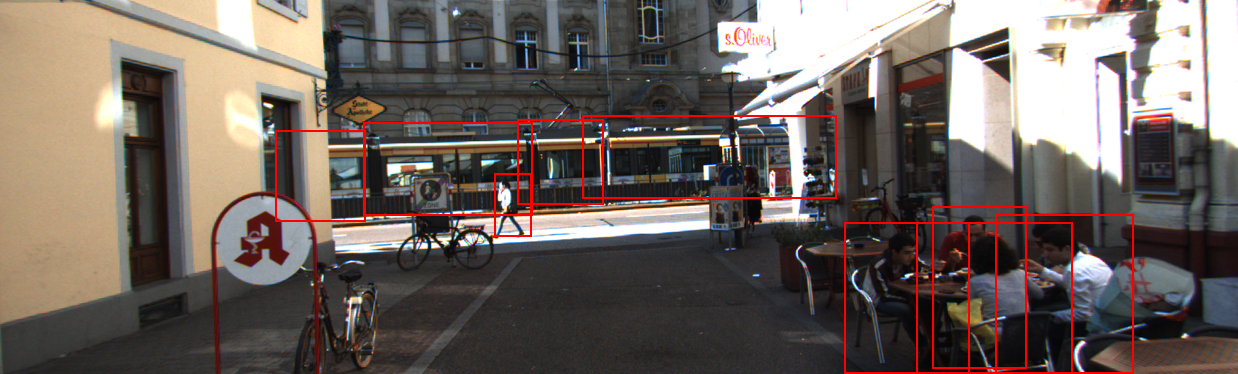

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_max = height - object_bbox[:,0] * height
    y_min = height - object_bbox[:,2] * height
    print(x_min, x_max, y_min, y_max)
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

---

### **(2) RetinaNet**

https://arxiv.org/abs/1708.02002

### **[데이터 파이프 라인]**  
  
1. x, y좌표 위치 교체  
  
2. 무작위로 수평 뒤집기(Flip)  
  
3. 이미지 크기 조정, 패딩 추가  
  
4. [x_min, y_min, x_max, y_max] -> [x_min, y_min, width, height] 로 수정

In [7]:
# x, y 좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

# 무작위로 수평 뒤집기
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

# 이미지 크기 조정 및 패딩 추가
# 이미지의 비율 << 그대로 유지
# 이미지 최대/최소 크기 제한
def resize_and_pad_image(image, training=True):
    
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    # ratio == min side를 image_shape 중 가장 작은 값으로 나눈 값
    ratio = min_side / tf.reduce_min(image_shape)   # tf.reduce_min : 가장 작은 값
    # (ratio * image_shape 중 가장 큰 값)이 max_side 보다 크다면
    if ratio * tf.reduce_max(image_shape) > max_side: 
        # ratio == max side를 image_shape 중 가장 큰 값으로 나눈 값  
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    # 최종적으로 모델에 입력되는 이미지의 크기 : stride의 배수
    # 모델에 입력되는 이미지 : 검정 테두리가 있음
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

# [x_min, y_min, x_max, y_max] -> [x_min, y_min, width, height] 로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [8]:
# 함수 연결
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)
    # bbox : left, top, right, bottom
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

---

### **[Anchor Box 생성]**

- **Bounding Box** : 모델이 추론한 물체의 위치가 표현된 박스 or 물체 위치의 실제값으로 데이터셋에 준비된 라벨. 물체마다 한 개
- **Anchor Box** : 모델이 추론해야 할 위치의 후보들. 물체가 있을 확률이 가장 높은 앵커 박스를 물체의 바운딩 박스로 예측. 학습 데이터의 라벨도 앵커 박스 형태로 바꾸어 주어야 함.

In [9]:
class AnchorBox:
    def __init__(self):
        # at each pyramid level we use anchors at three aspect ratios {1:2, 1:1, 2:1}
        self.aspect_ratios = [0.5, 1.0, 2.0]
        # For denser scale coverage than in [20], at each level we add anchors of sizes --
        # of the orginal set of 3 aspect ratio anchors.
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        # The anchors have areas of 32**2 to 512**2 on pyramid levels P3 to P7, respectively.
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

### **[IoU 계산]**  
  
-> Anchor Box가 정답인지 오답인지 체크

In [10]:
#  [x_min, y_min, width, height] -> [x_min, y_min, x_max, y_max] 로 수정인 듯
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    # 교집합 부분 구하기
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    # 합집합 부분 구하기
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [11]:
# 실제 라벨을 Anchor Box에 맞춰주는 Class
# compute_iou 함수를 통해 구한 IoU를 기준으로,
# 물체 Anchor Box와 배경 Anchor Box 지정 -> 실제 Bounding Box의 차이를 계싼
# 가로 세로 크기는 로그를 사용해서 기록
class LabelEncoder:
    
    def __init__(self):
        self._anchor_box = AnchorBox()
        # 상하좌우 0.1 가로세로 0.2 (관례적으로 사용)
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

### **[FPN]**  
  
- Feature Pyramid Network  
- 특성을 피라미드처럼 쌓아서 사용하는 방식
- CNN backborn network 에서는 다양한 layer의 output을 feature map으로 사용 가능한 
→ conv 연산 : 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약 → 입력 이미지 기준으로 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 cell이 넓은 이미지 영역의 정보를 담고 있음 << receptive field
: 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 가지는 것
- 백본의 여러 레이어를 한꺼번에 쓰겠다

- SSD  
    - 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식
- RetinaNet   
    - receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용. 
    - 레이어가 깊어질 수록 feature map의 w, h 방향의 receptive field가 넓어지는 것인데, 넓게보는 것과 좁게보는 것을 같이 쓰겠다는 목적

In [12]:
class FeaturePyramid(tf.keras.layers.Layer):
    
    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [13]:
# 두 번 호출하여 class label과 box label을 각각 추론
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

**[Backborn : ResNet50]**  

In [14]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    # FPN 위해 중간 레이어를 output으로 연결
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )


### **Backbone + FPN + classification용 head + box용 head**

In [15]:
class RetinaNet(tf.keras.Model):
    
    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

### **[Classification << Focal Loss]**  
  
물체를 배경보다 더 잘 학습하자 == 물체인 경우 loss를 작게  
- alpha, gamma로 물체일 때와 배경일 때의 식이 달라짐

- CE  
    - Cross Entropy : 교차 엔트로피  
    : ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단 → 손실 감소  
    B, 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어짐
- FL  
    - modulating factor * CE  
    - 이미지 : 극단적으로 배경의 class가 많은 class imbalanced data → modulating factor로 손실 조절  
    - γ==0 : modulating factor → 1 << 일반적인 교차 엔트로피  
    - γ가 커질 수록 modulating이 강하게 적용

### **[Box Regression << Smooth L1 Loss]**
- delta를 기준으로 계산이 달라짐

In [16]:
class RetinaNetBoxLoss(tf.losses.Loss):
    
    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

### **모델 학습**  
  
학습 환경에 적절하게 수정

In [17]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

In [18]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

### **데이터 전처리 파이프라인**

In [19]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [20]:
# model_dir = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/checkpoints/'
# callbacks_list = [
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
#         monitor="loss",
#         save_best_only=False,
#         save_weights_only=True,
#         verbose=1,
#     )
# ]

# epochs = 1

# model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     callbacks=callbacks_list
# )

In [21]:
# 학습된 모델 불러오기
model_dir = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

100개의 후보만 골라서 처리

### **[NMS]**  
  
Non-Max Suppression  

In [22]:
class DecodePredictions(tf.keras.layers.Layer):
    
    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

### **추론가능 모델 조립**

In [23]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)

# detections = DecodePredictions(confidence_threshold=0.5)(image, predictions) # 80점
# detections = DecodePredictions(confidence_threshold=0.5, nms_iou_threshold=0.4)(image, predictions) # 80점
detections = DecodePredictions(confidence_threshold=0.4, nms_iou_threshold=0.3)(image, predictions) # 90점
# detections = DecodePredictions(confidence_threshold=0.3, nms_iou_threshold=0.2)(image, predictions) # 90점
# detections = DecodePredictions(confidence_threshold=0.2, nms_iou_threshold=0.1)(image, predictions) # 90점

# detections = DecodePredictions(confidence_threshold=0.4, nms_iou_threshold=0.4)(image, predictions) # 90점
# detections = DecodePredictions(confidence_threshold=0.4, nms_iou_threshold=0.2)(image, predictions) # 90점

inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [24]:
# 시각화
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [25]:
# 추론을 위한 전처리 함수
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

### **학습 결과 확인**

2023-07-04 11:57:09.190503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


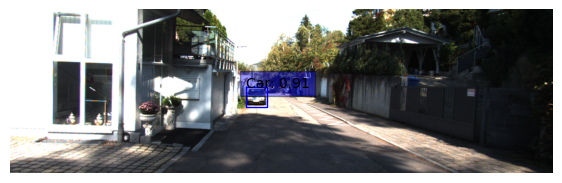

1/1 [==============================] - 0s 140ms/step


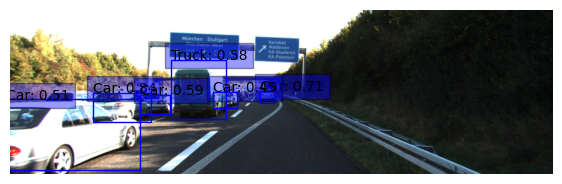

In [26]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

---

### **(3) 자율주행 보조 시스템 만들기**

1/1 [==============================] - 0s 151ms/step


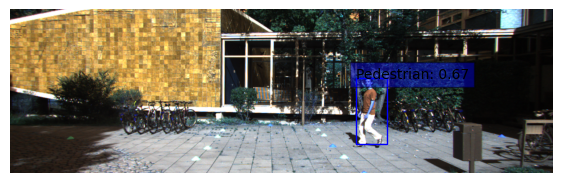

classes :  ['Pedestrian']
Stop


In [27]:
img_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    image = cv2.imread(img_path)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
    int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    scores = detections.nmsed_scores[0][:num_detections]
    visualize_detections(image, boxes, class_names, scores)
    print('classes : ', class_names)
    
    for box, cls_ in zip(boxes, class_names):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        
        # 사람이 한 명 이상 있을 때
        if cls_ == 'Pedestrian' or  cls_ == 'Person_sitting':
            return 'Stop'
    
        # 차량의 크기(width or height)가 300px 이상인 경우
        if cls_ == 'Car' or cls_ == 'Van' or cls_ == 'Truck':
            print('w : {}, h : {}'.format(w, h))
            if w >= size_limit or h >= size_limit:
                return 'Stop' 
            # else:
            #     return 'Go'
            
    return 'Go'

print(self_drive_assist(img_path))

1/1 [==============================] - 0s 136ms/step


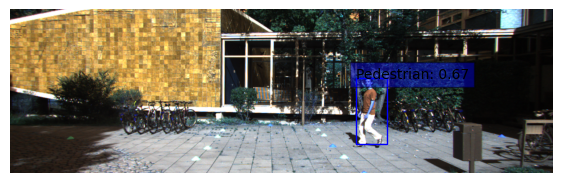

classes :  ['Pedestrian']
pred : Stop, answer : Stop
1/1 [==============================] - 0s 139ms/step


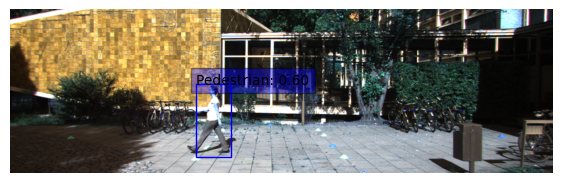

classes :  ['Pedestrian']
pred : Stop, answer : Stop
1/1 [==============================] - 0s 134ms/step


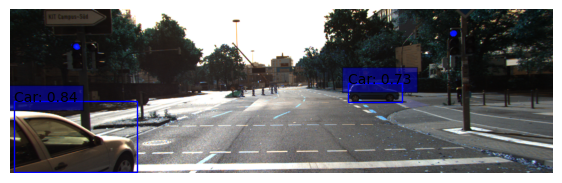

classes :  ['Car', 'Car']
w : 277.52642822265625, h : 159.95018005371094
w : 123.44842529296875, h : 41.84162902832031
pred : Go, answer : Stop
1/1 [==============================] - 0s 136ms/step


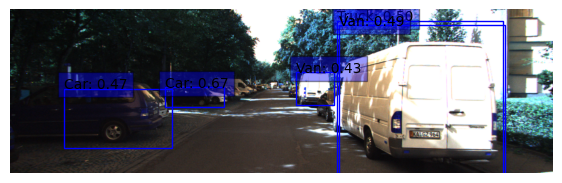

classes :  ['Car', 'Truck', 'Van', 'Car', 'Van']
w : 136.00985717773438, h : 44.59907531738281
w : 379.1036376953125, h : 355.1600646972656
pred : Stop, answer : Stop
1/1 [==============================] - 0s 162ms/step


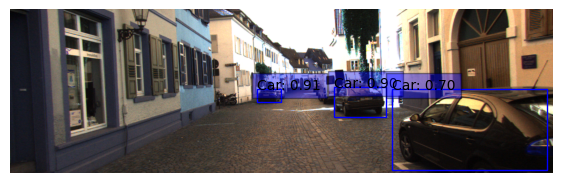

classes :  ['Car', 'Car', 'Car']
w : 54.81231689453125, h : 29.693756103515625
w : 120.1444091796875, h : 68.06925964355469
w : 354.31646728515625, h : 185.21945190429688
pred : Stop, answer : Stop
1/1 [==============================] - 0s 136ms/step


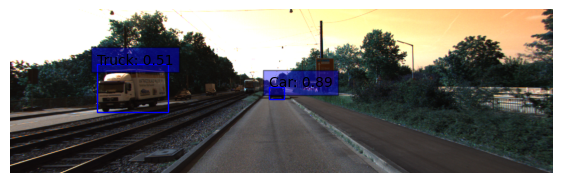

classes :  ['Car', 'Truck']
w : 34.0709228515625, h : 28.993789672851562
w : 163.69424438476562, h : 111.14456176757812
pred : Go, answer : Go
1/1 [==============================] - 0s 141ms/step


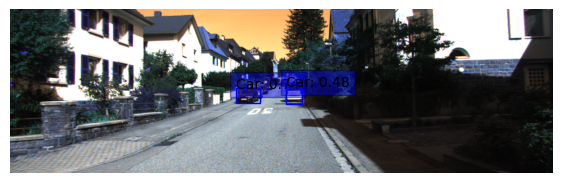

classes :  ['Car', 'Car']
w : 56.62176513671875, h : 34.26313781738281
w : 36.853271484375, h : 38.75431823730469
pred : Go, answer : Go
1/1 [==============================] - 0s 136ms/step


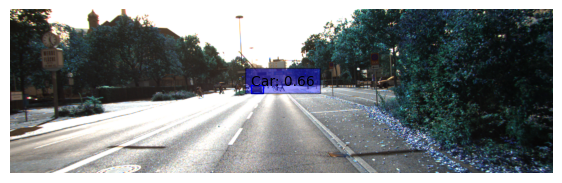

classes :  ['Car']
w : 27.78509521484375, h : 18.713836669921875
pred : Go, answer : Go
1/1 [==============================] - 0s 135ms/step


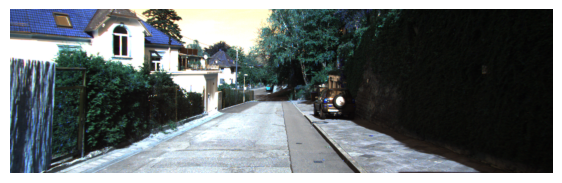

classes :  []
pred : Go, answer : Go
1/1 [==============================] - 0s 156ms/step


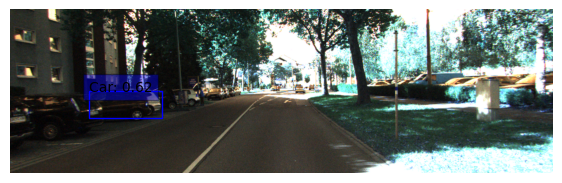

classes :  ['Car']
w : 168.7548370361328, h : 62.873008728027344
pred : Go, answer : Go
90점입니다.


In [28]:
def test_system(func):
    work_dir = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print('pred : {}, answer : {}'.format(pred, answer))
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

### **[Threshold 비교]**  
  
def DecodePrediction

| confidence_threshold | nms_iou_threshold |   점수     |  
|         :---:        |       :---:       |   :---:   |  
| 0.5                  | 0.5               | 80        |  
|                      | 0.4               | 80        |  
| **`0.4`**            | **`0.4`**         | **`90`**  |  
|                      | 0.3               | 90        |  
|                      | 0.2               | 90        |  
| 0.3                  | 0.2               | 90        |  
| 0.2                  | 0.1               | 90        |

- 같은 점수라면 threshold가 큰 것이 계산 비용에서 이득이기 때문에 각각 0.4로 설정  
- 맞추지 못한 1문제는 Truck이 score : 0.51, w : 354.31646728515625, h : 185.21945190429688로 나타남